In [192]:
import math
import numpy as np
from itertools import product, combinations, chain
from operator import sub
from scipy import optimize
import piecewise_regression

import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [216]:
# stochastically generates a ground truth trajectory 
def generate_traj(num_traj):
    t = []
    vol = []
    trajec_num = []

    for i in range(num_traj):
        t_0 = np.random.uniform(2.5, 3.5)
        t.append(t_0)

        candidate_w_1 = 100
        while candidate_w_1 > 2.5:
            candidate_w_1 = np.random.gamma(1, 1.5)
        t.append(t_0 + candidate_w_1 + 0.5)

        w_2 = np.random.uniform(4, 9)
        t.append(t_0 + candidate_w_1 + 0.5 + w_2)

        v_peak = np.random.uniform(7, 11)
        vol.extend([3, v_peak, 6])

        trajec_num.extend([i, i, i])
    
    df = np.array([t, vol, trajec_num])
    return(df)


In [ ]:
# given a trajectory traj and set of timestamps x
# generates the true value of y at each x
def get_y(traj, x):
    m_1 = (traj[1,1] - traj[1,0]) / (traj[0,1] - traj[0,0]) # slope of first line seg
    b_1 = traj[1,1] - (m_1 * traj[0,1]) # y-int of first line seg

    m_2 = (traj[1,2] - traj[1,1]) / (traj[0,2] - traj[0,1]) # slope of second line seg
    b_2 = traj[1,2] - (m_2 * traj[0,2]) # y-int of second line seg

    y = []
    for i in range(len(x)):
        if x[i] <= traj[0, 1]:
            y_i = (m_1 * x[i]) + b_1
        else:
            y_i = (m_2 * x[i]) + b_2
        
        y.append(y_i)
    
    return(y)

In [ ]:
# given the slope and intercept estimates and the breakpoint
# and a set of timestamps x
# predicts the values of y
def predictor(alpha, beta_1, beta_2, breakpoint_, x):
    y = []
    for i in range(len(x)):
        if x[i] <= breakpoint_:
            y_i = alpha + (beta_1 * x[i])
        else:
            y_i = alpha + (beta_1 * x[i]) + (beta_2 * (x[i] - breakpoint_))
        
        y.append(y_i)
    
    return(y)

In [ ]:
# samples num_samples points from the trajectory traj
def sample_traj(traj, num_samples):
    x = np.random.uniform(traj[0, 0],traj[0, 2], size = num_samples)

    y = get_y(traj, x)

    sampled_pts = np.array([x, y])

    return(sampled_pts)

In [217]:
# computes the denominator of the variance of the S1 estimate
def compute_s1_var_coeff(traj, sampled_pts):
    breakpoint_ = traj[0,1]
    sum_minus = 0
    num_minus = 0

    for x_i in sampled_pts[0]:
        if x_i <= breakpoint_:
            sum_minus += x_i
            num_minus += 1

    mean_minus = sum_minus / num_minus
    
    D_1 = 0
    for x_i in sampled_pts[0]:
        if x_i <= breakpoint_:
            D_1 += (x_i - mean_minus) ** 2

    return(D_1)

In [218]:
# computes the coefficient of the variance of the S2 estimate
def compute_s2_var_coeff(traj, sampled_pts):
    D_1 = compute_s1_var_coeff(traj, sampled_pts)

    breakpoint_ = traj[0,1]
    sum_plus = 0
    num_plus = 0
    for x_i in sampled_pts[0]:
        if x_i > breakpoint_:
            sum_plus += x_i
            num_plus += 1
    
    mean_plus = sum_plus / num_plus

    D_2 = 0
    for x_i in sampled_pts[0]:
        if x_i > breakpoint_:
            D_2 += (x_i - mean_plus) ** 2
    if D_1 == 0:
        return D_2
    if D_2 == 0:
        return D_1
    
    L = (D_1 + D_2) / (D_1 * D_2)

    return(L)

In [219]:
# computes estimates of alpha, beta_1, and beta_2 given a set of points
def get_slope_coeffs(breakpoint_, points):

    below_row_mask = points[:, 0] < breakpoint_

    below_break = points[below_row_mask]

    x_mean = sum(below_break[:,0]) / len(below_break[:,0])
    y_mean = sum(below_break[:,1]) / len(below_break[:,1])
    
    num = 0
    denom = 0
    for point in below_break:
        num += (point[0] - x_mean) * (point[1] - y_mean)
        denom += (point[0] - x_mean) ** 2
    
    beta_1 = num / denom

    alpha = y_mean - (beta_1 * x_mean)

    above_row_mask = points[:, 0] > breakpoint_

    above_break = points[above_row_mask]

    x_mean = sum(above_break[:,0]) / len(above_break[:,0])
    y_mean = sum(above_break[:,1]) / len(above_break[:,1])
    
    num = 0
    denom = 0
    for point in above_break:
        num += (point[0] - x_mean) * (point[1] - y_mean)
        denom += (point[0] - x_mean) ** 2
    
    beta_2 = (num / denom) - beta_1

    return(alpha, beta_1, beta_2)


# Find optimal point combinations

In [ ]:
# generate a trajectory and sample 25 noisy points from it 
num_points = 25
num_process = 5
traj = generate_traj(1)
sampled_pts = sample_traj(traj, num_points) 
error_x = np.random.normal(0, 0.1, num_points)
error_y = np.random.normal(0, 0.1, num_points)
sampled_pts = np.array([sampled_pts[0] + error_x, sampled_pts[1] + error_y])

# split the points into those below and above the breakpoint
row_mask = sampled_pts.T[:, 0] < traj[0,1]

below_break = sampled_pts.T[row_mask]

above_break = sampled_pts.T[~row_mask]

# generate a list of all pairs of integers which sum to num_process
# num process is the number of sampled points we will actually process (use for estimation) 
pairs = []
for sub in range(2, num_process - 1):
    pair = [sub, num_process - sub]
    pairs.append(pair)

# generate a list of all combinations of points
# which contain at least 2 points in each phase [this condition might be TOO STRONG]
all_combos = []
for pair in pairs:
    combinations_above = list(combinations(below_break, pair[0]))
    combinations_below = list(combinations(above_break, pair[1]))
    combinationsab = list(product(combinations_above, combinations_below))
    all_combos = all_combos + [combo[0] + combo[1] for combo in combinationsab]
all_combos = np.array(all_combos)

# find the set of points, points1, which minimizes variance of slope 1 estimator
maximum = 0
for combo in all_combos:
    L1 = compute_s1_var_coeff(traj, combo.T)
    if L1 > maximum:
        maximum = L1
        points1 = combo  

# find the set of points, points2, which minimizes variance of slope 2 estimator
minimum = 100000
for combo in all_combos:
    L2 = compute_s2_var_coeff(traj, combo.T)
    if L2 < minimum:
        minimum = L2
        points2 = combo      

# find the set of points, points3, which minimizes the total variance of the two slope estimators
overall_min = 100000000
for combo in all_combos:
    L1 = compute_s1_var_coeff(traj, combo.T)
    L2 = compute_s2_var_coeff(traj, combo.T)
    if (1 / L1) + L2 < overall_min:
        overall_min = (1 / L1) + L2
        points3 = combo       

# Performance when breakpoint is known

In [ ]:
# generate intercept and slope estimates from the points which minimized overall variance
alpha, beta_1, beta_2 = get_slope_coeffs(traj[0,1], points3)

In [ ]:
# generate predicted trajectory using intercept and slope estimates
pred_x = np.arange(traj[0,0], traj[0,2], 0.1)
pred_y = predictor(alpha, beta_1, beta_2, traj[0][1], pred_x)

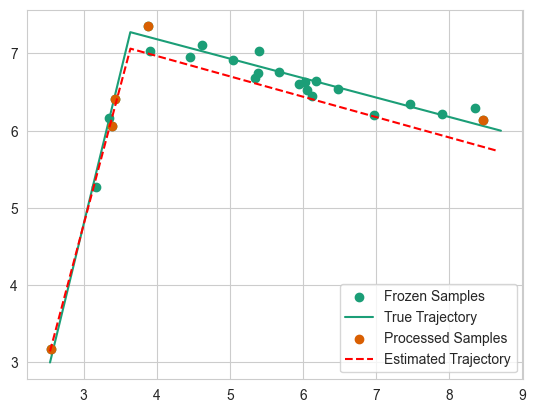

In [212]:
sns.set_style("whitegrid")
sns.set_palette("Dark2")
plt.scatter(sampled_pts[0], sampled_pts[1], zorder = 2, label = "Frozen Samples")
plt.plot(traj[0], traj[1], zorder = 1, label = "True Trajectory")
plt.scatter(points3.T[0], points3.T[1], zorder = 3, label = "Processed Samples")
plt.plot(pred_x, pred_y, zorder = 4, color='red', label='Estimated Trajectory', ls = "dashed")
plt.legend()

# Performance when breakpoint is not known

In [ ]:
# generate a two-phase linear model from the points which minimized overall variance
pw_fit = piecewise_regression.Fit(points3[:,0], points3[:,1], n_breakpoints=1)

In [ ]:
# use the two-phase linear model to estimate the trajectory
pred_y = pw_fit.predict(pred_x)

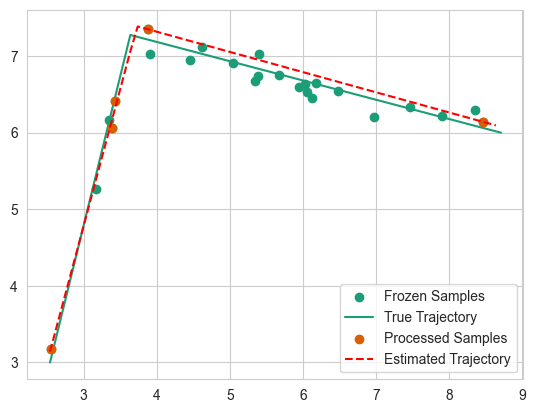

In [215]:
sns.set_style("whitegrid")
sns.set_palette("Dark2")
plt.scatter(sampled_pts[0], sampled_pts[1], zorder = 2, label = "Frozen Samples")
plt.plot(traj[0], traj[1], zorder = 1, label = "True Trajectory")
plt.scatter(points3.T[0], points3.T[1], zorder = 3, label = "Processed Samples")
plt.plot(pred_x, pred_y, zorder = 4, color='red', label='Estimated Trajectory', ls = "dashed")
plt.legend()